In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
flights = pd.read_csv('nycflights.csv', dtype = {'dep_time' : object, 
                                                 'dep_delay': object, 
                                                 'arr_time' : object, 
                                                 'arr_delay': object, 
                                                 'air_time' : object})
flights['date'] = pd.to_datetime({'year':flights.year, 'month':flights.month, 'day':flights.day})
def convert_time(column_name):
    the_min = flights[column_name][ flights[column_name].notnull() ].astype(str).str[-2:  ]
    the_hr  = flights[column_name][ flights[column_name].notnull() ].astype(str).str[  :-2]
    date_time = pd.to_datetime({'year':flights.year, 'month':flights.month, 'day':flights.day, 
                                'hour': the_hr, 'minute': the_min})
    # the magic of indexes allow us to combine flights.year which has all the rows
    # and the_hr which only exists for rows where dep_time is not NaN
    return date_time
dep_date_time       = convert_time('dep_time')
sched_dep_date_time = convert_time('sched_dep_time')
arr_date_time       = convert_time('arr_time')
sched_arr_date_time = convert_time('sched_arr_time')

datetimes = pd.concat({'dep_date_time': dep_date_time,
           'sched_dep_date_time': sched_dep_date_time, 
           'arr_date_time':arr_date_time, 
           'sched_arr_date_time':sched_arr_date_time}, axis = 1)
flights = flights.join(datetimes)  # we use the .join() function

### A Few Exercises

Find all flights that
- Had an arrival delay of two or more hours

In [4]:
flights.loc[flights.arr_delay.astype(float) > 120].shape

(10034, 24)

In [6]:
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,air_time,distance,hour,minute,time_hour,date,arr_date_time,dep_date_time,sched_arr_date_time,sched_dep_date_time
0,2013,1,1,517,515,2,830,819,11,UA,...,227,1400,5,15,1/1/2013 5:00,2013-01-01,2013-01-01 08:30:00,2013-01-01 05:17:00,2013-01-01 08:19:00,2013-01-01 05:15:00
1,2013,1,1,533,529,4,850,830,20,UA,...,227,1416,5,29,1/1/2013 5:00,2013-01-01,2013-01-01 08:50:00,2013-01-01 05:33:00,2013-01-01 08:30:00,2013-01-01 05:29:00
2,2013,1,1,542,540,2,923,850,33,AA,...,160,1089,5,40,1/1/2013 5:00,2013-01-01,2013-01-01 09:23:00,2013-01-01 05:42:00,2013-01-01 08:50:00,2013-01-01 05:40:00
3,2013,1,1,544,545,-1,1004,1022,-18,B6,...,183,1576,5,45,1/1/2013 5:00,2013-01-01,2013-01-01 10:04:00,2013-01-01 05:44:00,2013-01-01 10:22:00,2013-01-01 05:45:00
4,2013,1,1,554,600,-6,812,837,-25,DL,...,116,762,6,0,1/1/2013 6:00,2013-01-01,2013-01-01 08:12:00,2013-01-01 05:54:00,2013-01-01 08:37:00,2013-01-01 06:00:00


In [9]:
(flights.arr_date_time - flights.sched_arr_date_time) > pd.Timedelta(120, 'm')

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
336746    False
336747    False
336748    False
336749    False
336750    False
336751    False
336752    False
336753    False
336754    False
336755    False
336756    False
336757     True
336758    False
336759    False
336760    False
336761    False
336762    False
336763    False
336764    False
336765    False
336766    False
336767    False
336768    False
336769    False
336770    False
336771    False
336772    False
336773    False
336774    False
336775    False
Length: 336776, dtype: b

In [8]:
# must use timedelta for comparisons between time amounts 
flights.loc[ (flights.arr_date_time - flights.sched_arr_date_time) > pd.Timedelta(120, 'm') ].shape

(7474, 24)

### There is significant mismatch between these two results.

Let's explore what could be wrong.

In [10]:
a = flights.loc[flights.arr_delay.astype(float) > 120].index

In [11]:
b = flights.loc[ (flights.arr_date_time - flights.sched_arr_date_time) > pd.Timedelta(120, 'm') ].index

In [12]:
a.difference(b)

Int64Index([   151,    815,    830,    834,    843,   1755,   1762,   1786,
              2682,   2700,
            ...
            327616, 327644, 329260, 332163, 332176, 333175, 335773, 335777,
            335778, 336763],
           dtype='int64', length=2979)

In [13]:
flights.loc[151]

year                                  2013
month                                    1
day                                      1
dep_time                               848
sched_dep_time                        1835
dep_delay                              853
arr_time                              1001
sched_arr_time                        1950
arr_delay                              851
carrier                                 MQ
flight                                3944
tailnum                             N942MQ
origin                                 JFK
dest                                   BWI
air_time                                41
distance                               184
hour                                    18
minute                                  35
time_hour                   1/1/2013 18:00
date                   2013-01-01 00:00:00
arr_date_time          2013-01-01 10:01:00
dep_date_time          2013-01-01 08:48:00
sched_arr_date_time    2013-01-01 19:50:00
sched_dep_d

the flight departed the next day, and the full date-time column doesn't reflect this


In [14]:
flights.loc[10455,]

year                                  2013
month                                    1
day                                     13
dep_time                                10
sched_dep_time                        2135
dep_delay                              155
arr_time                               305
sched_arr_time                          36
arr_delay                              149
carrier                                 B6
flight                                  11
tailnum                             N595JB
origin                                 JFK
dest                                   FLL
air_time                               144
distance                              1069
hour                                    21
minute                                  35
time_hour                  1/13/2013 21:00
date                   2013-01-13 00:00:00
arr_date_time          2013-01-13 03:05:00
dep_date_time                          NaT
sched_arr_date_time                    NaT
sched_dep_d

I also found this flight, where the csv file says the departure time is '10'.

It should have read 00:10, as in 12:10AM, but maybe limitations of the csv export dropped the leading 0s.

In [16]:
a = np.array(['a','','c','d'])
a

array(['a', '', 'c', 'd'], dtype='<U1')

In [18]:
np.where(a == '', '100', a)

array(['a', '100', 'c', 'd'], dtype='<U3')

In [19]:
flights = pd.read_csv('nycflights.csv', dtype = {'dep_time' : object,  
                                                 'arr_time' : object, 
                                                 'air_time' : object})
flights['date'] = pd.to_datetime({'year':flights.year, 'month':flights.month, 'day':flights.day})

def convert_time(column_name):
    the_min = flights[column_name][ flights[column_name].notnull() ].astype(str).str[-2:  ]
    the_hr  = flights[column_name][ flights[column_name].notnull() ].astype(str).str[  :-2]
    
    # this following line says that if the hr extracted from strings is empty, '', 
    # then replace it with 00, otherwise, use the hr that appears, and preserve the index
    the_hr  = pd.Series( np.where(the_hr == '', '00',the_hr) , index = the_hr.index)
    
    date_time = pd.to_datetime({'year':flights.year, 'month':flights.month, 'day':flights.day, 
                                'hour': the_hr, 'minute': the_min})
    return date_time

sched_dep_date_time = convert_time('sched_dep_time')
sched_arr_date_time = convert_time('sched_arr_time')

dep_date_time       = sched_dep_date_time + pd.to_timedelta(flights.dep_delay, 'm')
arr_date_time       = sched_arr_date_time + pd.to_timedelta(flights.arr_delay, 'm')

# clean up
# if a flight lands on the following day, we need to update that as well
# this shows that if the arr_date is before the dep_date, add 24 hours to the arrival times
sched_arr_date_time = pd.Series( np.where(sched_arr_date_time < sched_dep_date_time, 
                                          sched_arr_date_time + pd.Timedelta(24, 'h'), 
                                          sched_arr_date_time
                                         ) , index = sched_arr_date_time.index)
arr_date_time = pd.Series( np.where(arr_date_time < dep_date_time,
                                    arr_date_time + pd.Timedelta(24, 'h'),
                                    arr_date_time) , index = arr_date_time.index)

datetimes = pd.concat({'dep_date_time': dep_date_time,
           'sched_dep_date_time': sched_dep_date_time, 
           'arr_date_time':arr_date_time, 
           'sched_arr_date_time':sched_arr_date_time}, axis = 1)
flights = flights.join(datetimes)  # we use the .join() function
flights = flights.drop(['year','month','day'], axis = 1)
airlines = pd.read_csv('airlines.csv', index_col = 'carrier')

In [20]:
flights.loc[151,]

dep_time                               848
sched_dep_time                        1835
dep_delay                              853
arr_time                              1001
sched_arr_time                        1950
arr_delay                              851
carrier                                 MQ
flight                                3944
tailnum                             N942MQ
origin                                 JFK
dest                                   BWI
air_time                                41
distance                               184
hour                                    18
minute                                  35
time_hour                   1/1/2013 18:00
date                   2013-01-01 00:00:00
arr_date_time          2013-01-02 10:01:00
dep_date_time          2013-01-02 08:48:00
sched_arr_date_time    2013-01-01 19:50:00
sched_dep_date_time    2013-01-01 18:35:00
Name: 151, dtype: object

In [22]:
flights.loc[10455,]

dep_time                                10
sched_dep_time                        2135
dep_delay                              155
arr_time                               305
sched_arr_time                          36
arr_delay                              149
carrier                                 B6
flight                                  11
tailnum                             N595JB
origin                                 JFK
dest                                   FLL
air_time                               144
distance                              1069
hour                                    21
minute                                  35
time_hour                  1/13/2013 21:00
date                   2013-01-13 00:00:00
arr_date_time          2013-01-14 03:05:00
dep_date_time          2013-01-14 00:10:00
sched_arr_date_time    2013-01-14 00:36:00
sched_dep_date_time    2013-01-13 21:35:00
Name: 10455, dtype: object

Note to self: maybe we need to check if it is possible for a flight to be delayed over 24 hours (or maybe they all just get cancelled)

In [23]:
flights.loc[flights.arr_delay.astype(float) > 120].shape

(10034, 21)

In [24]:
flights.loc[ (flights.arr_date_time - flights.sched_arr_date_time) > pd.Timedelta(120, 'm') ].shape

(10034, 21)

Now our results match!

Find all flights that:
- Flew to Houston (IAH or HOU)
- Were operated by United, American, or Delta
- Departed in summer (July, August, and September)
- Arrived more than two hours late, but didn’t leave late
- Were delayed by at least an hour, but made up over 30 minutes in flight
- Departed between midnight and 6am (inclusive)

In [27]:
# Flew to Houston (IAH or HOU)
flights.loc[ flights.dest.isin(['IAH','HOU']) ].shape

(9313, 21)

In [28]:
# Were operated by United, American, or Delta
flights.loc[ flights.carrier.isin(['UA','AA', 'DL']) ].shape

(139504, 21)

In [29]:
# Departed in summer (July, August, and September)
flights.loc[ flights.dep_date_time.dt.month.isin([7,8,9]) ].shape

(84457, 21)

In [30]:
# Arrived more than two hours late, but didn’t leave late
# use & for making element-wise boolean comparisons
flights.loc[ (flights.arr_delay > 120) & (flights.dep_delay <= 0) ].head()

,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,...,air_time,distance,hour,minute,time_hour,date,arr_date_time,dep_date_time,sched_arr_date_time,sched_dep_date_time
22911,1419,1420,-1.0,1754,1550,124.0,MQ,3728,N1EAMQ,EWR,...,135,719,14,20,1/27/2013 14:00,2013-01-27,2013-01-27 17:54:00,2013-01-27 14:19:00,2013-01-27 15:50:00,2013-01-27 14:20:00
33011,1350,1350,0.0,1736,1526,130.0,EV,5181,N611QX,LGA,...,117,812,13,50,10/7/2013 13:00,2013-10-07,2013-10-07 17:36:00,2013-10-07 13:50:00,2013-10-07 15:26:00,2013-10-07 13:50:00
33019,1357,1359,-2.0,1858,1654,124.0,AA,1151,N3CMAA,LGA,...,192,1389,13,59,10/7/2013 13:00,2013-10-07,2013-10-07 18:58:00,2013-10-07 13:57:00,2013-10-07 16:54:00,2013-10-07 13:59:00
41075,657,700,-3.0,1258,1056,122.0,B6,3,N703JB,JFK,...,225,1598,7,0,10/16/2013 7:00,2013-10-16,2013-10-16 12:58:00,2013-10-16 06:57:00,2013-10-16 10:56:00,2013-10-16 07:00:00
55985,658,700,-2.0,1329,1015,194.0,VX,399,N629VA,JFK,...,336,2475,7,0,11/1/2013 7:00,2013-11-01,2013-11-01 13:29:00,2013-11-01 06:58:00,2013-11-01 10:15:00,2013-11-01 07:00:00


In [32]:
flights.loc[ (flights.arr_delay > 120) & (flights.dep_delay <= 0) ].shape

(29, 21)

In [31]:
# Were delayed by at least an hour, but made up over 30 minutes in flight

flights.loc[ (flights.dep_delay >= 60) & (flights.arr_delay <= flights.dep_delay - 30) ].head()

,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,...,air_time,distance,hour,minute,time_hour,date,arr_date_time,dep_date_time,sched_arr_date_time,sched_dep_date_time
593,1716,1545,91.0,2140,2039,61.0,B6,703,N651JB,JFK,...,183,1598,15,45,1/1/2013 15:00,2013-01-01,2013-01-01 21:40:00,2013-01-01 17:16:00,2013-01-01 20:39:00,2013-01-01 15:45:00
815,2205,1720,285.0,46,2040,246.0,AA,1999,N5DNAA,EWR,...,146,1085,17,20,1/1/2013 17:00,2013-01-01,2013-01-02 00:46:00,2013-01-01 22:05:00,2013-01-01 20:40:00,2013-01-01 17:20:00
832,2326,2130,116.0,131,18,73.0,B6,199,N594JB,JFK,...,290,2248,21,30,1/1/2013 21:00,2013-01-01,2013-01-02 01:31:00,2013-01-01 23:26:00,2013-01-02 00:18:00,2013-01-01 21:30:00
2286,1503,1221,162.0,1803,1555,128.0,UA,551,N835UA,EWR,...,320,2565,12,21,1/3/2013 12:00,2013-01-03,2013-01-03 18:03:00,2013-01-03 15:03:00,2013-01-03 15:55:00,2013-01-03 12:21:00
2495,1821,1530,171.0,2131,1910,141.0,AA,85,N357AA,JFK,...,328,2586,15,30,1/3/2013 15:00,2013-01-03,2013-01-03 21:31:00,2013-01-03 18:21:00,2013-01-03 19:10:00,2013-01-03 15:30:00


In [33]:
flights.loc[ (flights.dep_delay >= 60) & (flights.arr_delay <= flights.dep_delay - 30) ].shape

(2074, 21)

In [35]:
# Departed between midnight and 5:59am

flights.loc[  flights.dep_date_time.dt.hour.between(0,5)  ].shape

(8759, 21)

### Which day of the week is busiest?

In [37]:
w = flights.groupby(dep_date_time.dt.weekday).date.count()  # monday = 0, sunday = 6
# produces a series
w

0.0    49445
1.0    49354
2.0    48813
3.0    48598
4.0    48732
5.0    38033
6.0    45546
Name: date, dtype: int64

In [39]:
d = pd.DataFrame(w)
# rename the index of a dataframe with a dictionary
d.rename({0:'Mon', 1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}, axis = 'index', inplace = True)
d

,date
Mon,49445
Tue,49354
Wed,48813
Thu,48598
Fri,48732
Sat,38033
Sun,45546


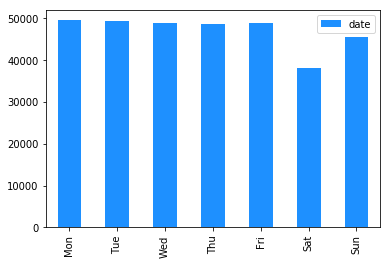

In [42]:
d.plot(kind = 'bar', color = 'dodgerblue')
plt.show()

In [44]:
flights.groupby(dep_date_time.dt.weekday_name).date.count()
# by default it sorts alphabetically

Friday       48732
Monday       49445
Saturday     38033
Sunday       45546
Thursday     48598
Tuesday      49354
Wednesday    48813
Name: date, dtype: int64

In [48]:
flights.groupby(dep_date_time.dt.day_name('spanish')).date.count()  # I later learned of day_name()
# you need to specify the language to use

Domingo      45546
Jueves       48598
Lunes        49445
Martes       49354
Miércoles    48813
Sábado       38033
Viernes      48732
Name: date, dtype: int64

### Which carriers fly out of which airports?

In [49]:
# multi-index
flights.groupby(['carrier','origin']).flight.count()

carrier  origin
9E       EWR        1268
         JFK       14651
         LGA        2541
AA       EWR        3487
         JFK       13783
         LGA       15459
AS       EWR         714
B6       EWR        6557
         JFK       42076
         LGA        6002
DL       EWR        4342
         JFK       20701
         LGA       23067
EV       EWR       43939
         JFK        1408
         LGA        8826
F9       LGA         685
FL       LGA        3260
HA       JFK         342
MQ       EWR        2276
         JFK        7193
         LGA       16928
OO       EWR           6
         LGA          26
UA       EWR       46087
         JFK        4534
         LGA        8044
US       EWR        4405
         JFK        2995
         LGA       13136
VX       EWR        1566
         JFK        3596
WN       EWR        6188
         LGA        6087
YV       LGA         601
Name: flight, dtype: int64

In [50]:
flights.groupby(['carrier','origin']).flight.count().index

MultiIndex(levels=[['9E', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'FL', 'HA', 'MQ', 'OO', 'UA', 'US', 'VX', 'WN', 'YV'], ['EWR', 'JFK', 'LGA']],
           labels=[[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 7, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 14, 14, 15], [0, 1, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 1, 0, 1, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 1, 0, 2, 2]],
           names=['carrier', 'origin'])

You can make a 'pivot table' by unstacking the multi-index

In [51]:
flights.groupby(['carrier','origin']).flight.count().unstack()

origin,EWR,JFK,LGA
carrier,,,
9E,1268.0,14651.0,2541.0
AA,3487.0,13783.0,15459.0
AS,714.0,NaN,NaN
B6,6557.0,42076.0,6002.0
DL,4342.0,20701.0,23067.0
EV,43939.0,1408.0,8826.0
F9,NaN,NaN,685.0
FL,NaN,NaN,3260.0
HA,NaN,342.0,NaN


You can also make a pivot table using the pivot_table method.

In [52]:
flights.pivot_table('flight',index = 'carrier', columns = 'origin', aggfunc = 'count')

origin,EWR,JFK,LGA
carrier,,,
9E,1268.0,14651.0,2541.0
AA,3487.0,13783.0,15459.0
AS,714.0,NaN,NaN
B6,6557.0,42076.0,6002.0
DL,4342.0,20701.0,23067.0
EV,43939.0,1408.0,8826.0
F9,NaN,NaN,685.0
FL,NaN,NaN,3260.0
HA,NaN,342.0,NaN


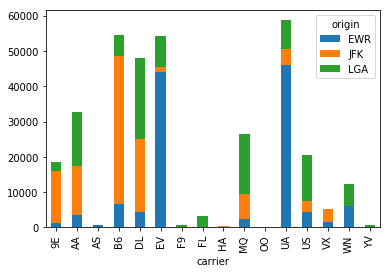

In [53]:
flights.pivot_table('flight',index = 'carrier', 
                    columns = 'origin', aggfunc = 'count').plot.bar(stacked = True)

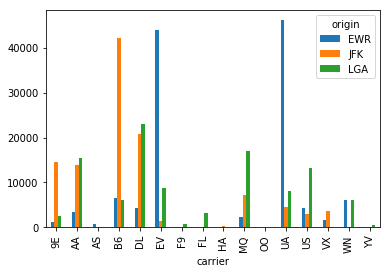

In [54]:
flights.pivot_table('flight',index = 'carrier', 
                    columns = 'origin', aggfunc = 'count').plot.bar()

You can see the top 4 carriers: B6, DL, EV, UA

It appears:
- B6 flies out of JFK the most.
- DL uses JFK and LGA equally
- EV uses EWR heavily
- UA uses EWR heavily as well


I'm curious to see for each of the airports, if one of the carriers will have more 'clout' because it is a bigger user of the airport.

In [55]:
ewr = flights.loc[flights.origin == 'EWR'].groupby('carrier').flight.count().sort_values(
    ascending = False)
ewr

carrier
UA    46087
EV    43939
B6     6557
WN     6188
US     4405
DL     4342
AA     3487
MQ     2276
VX     1566
9E     1268
AS      714
OO        6
Name: flight, dtype: int64

 I was curious if the proportion of UA and EV flights that are delayed is less than some of the smaller carrier.... maybe these big airlines get higher priority?? 

### Let's look at flights to Los Angeles

In [56]:
la = flights.loc[flights.dest.isin(['LAX','BUR','ONT','LGB'])]

In [57]:
la.dest.unique()

array(['LAX', 'LGB', 'BUR'], dtype=object)

In [58]:
la.dest.value_counts()

LAX    16174
LGB      668
BUR      371
Name: dest, dtype: int64

In [59]:
la.carrier.value_counts()

UA    5823
AA    3582
B6    2727
VX    2580
DL    2501
Name: carrier, dtype: int64

In [60]:
la.groupby('dest').carrier.value_counts()

dest  carrier
BUR   B6          371
LAX   UA         5823
      AA         3582
      VX         2580
      DL         2501
      B6         1688
LGB   B6          668
Name: carrier, dtype: int64

B6 (JetBlue) is the only carrier that goes to Burbank or Long Beach. There are no flights from Ontario to New York.

In [ ]:
la.groupby('dest').origin.value_counts()

No direct flights from LaGuardia to Los Angeles. If you want to fly direct to Burbank or Long Beach, you must depart from JFK. 

In [ ]:
la.dep_delay[la.dep_delay.notnull()].astype(int).groupby(la.dest).mean()